In [5]:
import pandas as pd
import numpy as np
import math
from joblib import load
import json

In [2]:
df = pd.read_csv('./data/playLibrary_v2.csv')

In [3]:
df['scoreDiff'] = df['shooterTeamScore'] - df['goalieTeamScore']
df['isOT'] = (df['period']/4).apply(lambda x: math.floor(x))
df['distance'] = ((89 - df['x'])*(89 - df['x']) + (df['y']*df['y']))**(0.5)
df['angle'] = (df['y']/df['distance']).apply(lambda x: math.asin(x)*180/math.pi)
df['shooterIsHome'] = pd.get_dummies(df['shooterHomeAway'],drop_first=True)
df = df.join(pd.get_dummies(df['shotType'],drop_first=True))
df = df.join(pd.get_dummies(df['shooter']))
df['target'] = pd.get_dummies(df['play'])['GOAL']

In [9]:
X = df.drop(columns=['target','period','shotType','shooterHomeAway','goalie','shooter','play'])
y = df['target']

In [11]:
scaler = load('scaler.bin')
model = load('gbGoalie_2March2020.joblib')

In [12]:
X_scaled = scaler.transform(X)

In [15]:
goalProb = model.predict_proba(X_scaled)[:,1]

In [60]:
np.round(goalProb, 3)

array([0.032, 0.197, 0.088, ..., 0.019, 0.11 , 0.035])

In [22]:
df.columns[0:30]
filtDF = df[['goalie','period','x','y','shotType','target']]

In [24]:
filtDF.loc[:,'goalProb'] = goalProb

/Users/josephpicca/anaconda/envs/grib/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
goalieID = 8477293
filtDF[filtDF['goalie'] == 	goalieID]['target'].sum()/filtDF[filtDF['goalie'] == goalieID]['goalProb'].sum()

0.909653519179277

In [50]:
filtDF['goalie'].unique()

array([8471239, 8476316, 8478406, 8475622, 8479394, 8475156, 8471695,
       8475683, 8480382, 8477967, 8477293, 8470147, 8473503, 8476945,
       8479496, 8474593, 8467950, 8476899, 8476234, 8477465, 8475839,
       8473541, 8478039, 8471679, 8476999, 8476876, 8470645, 8471469,
       8471750, 8480925, 8475311, 8468011, 8478492, 8480213, 8476914,
       8475215, 8474636, 8470860, 8473575, 8475831, 8471306, 8478048,
       8474651, 8475883, 8478007, 8477405, 8479292, 8470880, 8479312,
       8477361, 8478470, 8475852, 8476412, 8474889, 8475195, 8476883,
       8476434, 8471734, 8471227, 8470657, 8475717, 8477424, 8470594,
       8468685, 8469608, 8471774, 8475660, 8480162, 8471418, 8477180,
       8476861, 8478499, 8475789, 8479288, 8477480, 8476904, 8474596,
       8477992, 8480051, 8479188, 8477968, 8476343, 8479530, 8477312,
       8480022, 8476341])

In [61]:
testDF = pd.read_csv('./data/dataToFilter.csv')

In [101]:
testDF

,goalie,period,x,y,shotType,target,goalProb
0,8471239,1,48.0,-22.0,Snap Shot,0,0.032
1,8476316,1,86.0,-6.0,Snap Shot,0,0.197
2,8471239,1,66.0,11.0,Wrist Shot,0,0.088
3,8471239,1,54.0,4.0,Wrist Shot,0,0.073
4,8476316,1,52.0,36.0,Snap Shot,0,0.021
...,...,...,...,...,...,...,...
64015,8471418,3,8.0,39.0,Wrist Shot,0,0.013
64016,8475156,3,77.0,-1.0,Tip-In,0,0.213
64017,8471418,4,81.0,9.0,Snap Shot,0,0.215
64018,8471418,4,67.0,-14.0,Wrist Shot,0,0.083


In [79]:
goalieDF = df[(df['goalie'] == 8480051)]
allowedDF = df[(df['goalie'] == 8480051) & (df['play'] == 'GOAL')]

In [63]:
from griddertest import Gridder

In [121]:
def createGrid(dx=10,dy=10):

    # Create arrays for gridding
    x_axis = np.arange(-100,100,dx)
    y_axis = np.arange(-42.5,42.5,dy)

    # Create our meshgrid from our arrays
    X, Y = np.meshgrid(x_axis, y_axis)

    # Set up the grid
    G = Gridder(X,Y)

    return G

In [122]:
# Create grid object
G = createGrid()

totalGrid = np.zeros(G.tx.shape)
allowedGrid = np.zeros(G.tx.shape)

allPoints = G.grid_points(goalieDF['x'], goalieDF['y'])  # Run the Gridder!
allowedPoints = G.grid_points(allowedDF['x'], allowedDF['y']) 

In [123]:
for idx,point in enumerate(allPoints):
    totalGrid[point] += 1*testDF['goalProb'][idx]

In [124]:
for idx,point in enumerate(allowedPoints):
    allowedGrid[point] += 1

In [125]:
allowedGrid - totalGrid

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.248, -0.215, -0.19 , -0.237, -0.837, -0.6  ,  0.112,
        -0.732,  0.898,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.163, -0.047,  0.   , -0.033,  0.   ,
         0.   , -0.129, -0.125, -0.047, -0.043, -2.083, -2.315, -1.83 ,
        -0.943, -0.568,  0.715,  0.   ],
       [ 0.   , -0.125,  0.   ,  0.   ,  0.   , -0.13 ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.135, -2.29 ,  0.198, -1.182,
        -1.141, -1.391,  1.307, -0.161],
       [-0.224,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.176,  0.   ,  0.   , -0.169,  0.   , -0.06 , -0.589, -0.235,
         0.008,  1.21 ,  2.695,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.124,  0.   ,  0.   ,  0.   ,
         0.   , -0.112, -0.094, -0.474, -0.526, -1.181, -0.061,  0.025,
         1.455,  6.616,  3.637,  0.   ],
       [-0.046, -0.078,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
   

In [7]:
df = pd.read_csv('./data/dataToFilter.csv')

In [142]:
df['x'] = df['x'].apply(lambda x: abs(x))

In [163]:
goalieID = 8471750
goalieDF = df[(df['goalie'] == int(goalieID))].reset_index(drop=True)
allowedDF = df[(df['goalie'] == int(goalieID)) & (df['target'] == 1)].reset_index(drop=True)

In [164]:
# Create grid object
G = createGrid()
totalGrid = np.zeros(G.tx.shape)
allowedGrid = np.zeros(G.tx.shape)

allPoints = G.grid_points(goalieDF['x'], goalieDF['y'])  # Run the Gridder!
allowedPoints = G.grid_points(allowedDF['x'], allowedDF['y']) 

In [165]:
for idx,point in enumerate(allPoints):
    totalGrid[point] += goalieDF['goalProb'][idx]

In [166]:
for idx,point in enumerate(allowedPoints):
    allowedGrid[point] += 1

In [168]:
np.max(totalGrid-allowedGrid)

4.526999999999999

In [126]:
import requests

In [127]:
url = f'https://statsapi.web.nhl.com/api/v1/people/{goalieID}/stats?stats=statsSingleSeason&season=20192020'

In [129]:
response = requests.get(url)

In [136]:
timeList = response.json()['stats'][0]['splits'][0]['stat']['timeOnIce'].split(':')

In [137]:
minOnIce = int(timeList[0]) + int(timeList[1])/60

In [138]:
minOnIce/60

27.01361111111111

In [174]:
df[(df['goalie'] == 8471750) & (df['target'] == 1)].loc[df['x'] == 13,:]

,goalie,period,x,y,shotType,target,goalProb
53575,8471750,2,13.0,-2.0,Wrist Shot,1,0.02


In [240]:
with open('./data/goalies.json', 'r') as file:
    baseDict = json.load(file)

In [251]:
per60Dict = {}

for value in baseDict.values():
    url = f'https://statsapi.web.nhl.com/api/v1/people/{value}/stats?stats=statsSingleSeason&season=20192020'
    
    print(f'Getting TOI data for {value}...')
    response = requests.get(url)
    
    timeList = response.json()['stats'][0]['splits'][0]['stat']['timeOnIce'].split(':')
    minOnIce = int(timeList[0]) + int(timeList[1])/60
    
    per60 = np.round(minOnIce/60,2)
    
    # Get goalie's team
    url = f'https://statsapi.web.nhl.com/api/v1/people/{value}'
    response = requests.get(url).json()
    team = response['people'][0]['currentTeam']['name'].split(' ')[-1]
    
    per60Dict[value] = {'games': per60, 'currTeam': team}

Getting TOI data for 8471239...
Getting TOI data for 8476316...
Getting TOI data for 8478406...
Getting TOI data for 8475622...
Getting TOI data for 8479394...
Getting TOI data for 8475156...
Getting TOI data for 8471695...
Getting TOI data for 8475683...
Getting TOI data for 8480382...
Getting TOI data for 8477967...
Getting TOI data for 8477293...
Getting TOI data for 8470147...
Getting TOI data for 8473503...
Getting TOI data for 8476945...
Getting TOI data for 8479496...
Getting TOI data for 8474593...
Getting TOI data for 8467950...
Getting TOI data for 8476899...
Getting TOI data for 8476234...
Getting TOI data for 8477465...
Getting TOI data for 8475839...
Getting TOI data for 8473541...
Getting TOI data for 8478039...
Getting TOI data for 8471679...
Getting TOI data for 8476999...
Getting TOI data for 8476876...
Getting TOI data for 8470645...
Getting TOI data for 8471469...
Getting TOI data for 8471750...
Getting TOI data for 8480925...
Getting TOI data for 8475311...
Getting 

In [252]:
per60Dict

{'8471239': {'games': 10.32, 'currTeam': 'Devils'},
 '8476316': {'games': 16.46, 'currTeam': 'Jets'},
 '8478406': {'games': 42.74, 'currTeam': 'Devils'},
 '8475622': {'games': 28.63, 'currTeam': 'Sabres'},
 '8479394': {'games': 37.31, 'currTeam': 'Flyers'},
 '8475156': {'games': 33.24, 'currTeam': 'Oilers'},
 '8471695': {'games': 38.04, 'currTeam': 'Bruins'},
 '8475683': {'games': 46.77, 'currTeam': 'Panthers'},
 '8480382': {'games': 30.5, 'currTeam': 'Rangers'},
 '8477967': {'games': 22.44, 'currTeam': 'Canucks'},
 '8477293': {'games': 30.38, 'currTeam': 'Coyotes'},
 '8470147': {'games': 16.93, 'currTeam': 'Lightning'},
 '8473503': {'games': 22.97, 'currTeam': 'Hurricanes'},
 '8476945': {'games': 51.48, 'currTeam': 'Jets'},
 '8479496': {'games': 45.54, 'currTeam': 'Flames'},
 '8474593': {'games': 42.53, 'currTeam': 'Canucks'},
 '8467950': {'games': 28.78, 'currTeam': 'Senators'},
 '8476899': {'games': 35.35, 'currTeam': 'Penguins'},
 '8476234': {'games': 5.67, 'currTeam': 'Canadiens'}

In [253]:
# Save the updated dict to a json file
with open('./data/goalieTime.json','w') as file:
    json.dump(per60Dict, file)

In [191]:
np.sum(allowedGrid)

98.0

In [8]:
goalieID = 8471750
goalieDF = df[(df['goalie'] == int(goalieID))].reset_index(drop=True)
allowedDF = df[(df['goalie'] == int(goalieID)) & (df['target'] == 1)].reset_index(drop=True)

In [6]:
with open('./data/goalieTime.json', 'r') as file:
    baseDict = json.load(file)

In [9]:
expectedGoals = goalieDF['goalProb'].sum()/baseDict[str(goalieID)]['games']
allowedGoals = allowedDF['target'].sum()/baseDict[str(goalieID)]['games']

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.image as mpimg
img=mpimg.imread('./static/teamLogos/stars.png')

Text(0, 0.5, 'Goals Against Average')

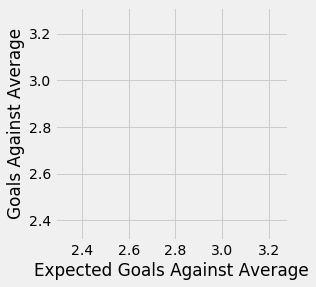

In [284]:
#plt.scatter(expectedGoals,allowedGoals)
plt.imshow(img,extent=(expectedGoals-0.05,expectedGoals+0.05,allowedGoals-0.05,allowedGoals+0.05))
plt.xlim([avgExp-0.5,avgExp+0.5])
plt.xlabel('Expected Goals Against Average')
plt.ylim([avgGAA-0.5,avgGAA+0.5])
plt.ylabel('Goals Against Average')

(2.05, 3.55)

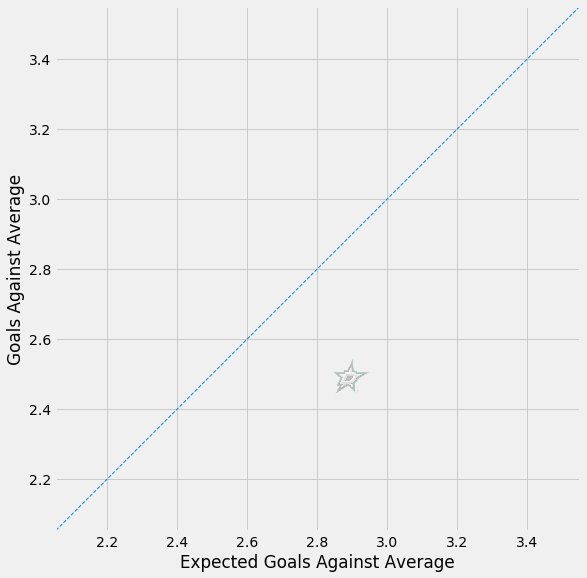

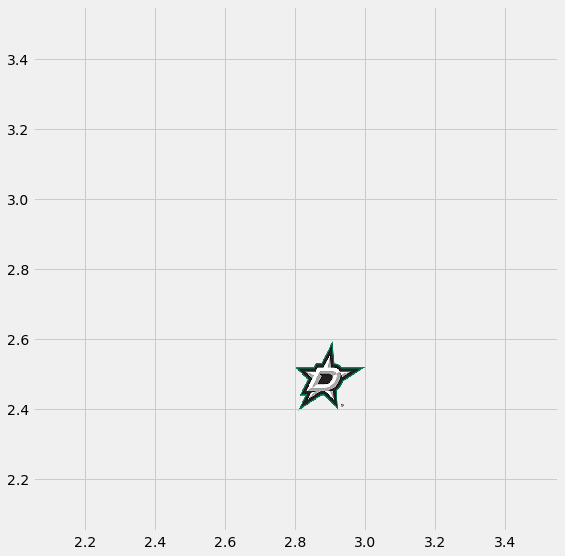

In [16]:
fig,ax = plt.subplots(figsize=(9,9))
plt.plot([0,4],[0,4],linestyle='dashed',linewidth=1)

#for goalie in baseDict.keys():

goalie = "8471750"
fig2,ax2 = plt.subplots(figsize=(9,9))
img=mpimg.imread(f'./static/teamLogos/{baseDict[goalie]["currTeam"]}.png')

goalieDF = df[(df['goalie'] == int(goalie))].reset_index(drop=True)
allowedDF = df[(df['goalie'] == int(goalie)) & (df['target'] == 1)].reset_index(drop=True)

expectedGoals = goalieDF['goalProb'].sum()/baseDict[goalie]['games']
allowedGoals = allowedDF['target'].sum()/baseDict[goalie]['games']

ax.imshow(img,extent=(expectedGoals-0.05,expectedGoals+0.05,allowedGoals-0.05,allowedGoals+0.05),alpha=0.25)
ax.set_xlim([2.8-0.75,2.8+0.75])
ax.set_xlabel('Expected Goals Against Average')
ax.set_ylim([2.8-0.75,2.8+0.75])
ax.set_ylabel('Goals Against Average')

ax2.imshow(img,extent=(expectedGoals-0.1,expectedGoals+0.1,allowedGoals-0.1,allowedGoals+0.1))
ax2.set_xlim([2.8-0.75,2.8+0.75])
ax2.set_ylim([2.8-0.75,2.8+0.75])
#fig2.savefig(f'./static/images/{goalie}',ax=ax2,dpi=100,transparent=True)
                     
#fig.savefig('./static/images/test.png',dpi=100)

In [14]:
with open('./data/goalieTime.json', 'r') as file:
    goalieDict = json.load(file)

Calculate sum of games for all goalies

In [15]:
totalGames = 0
for goalie in goalieDict:
    totalGames += goalieDict[goalie]

TypeError: unsupported operand type(s) for +=: 'int' and 'dict'

Average Goals Against Average

In [12]:
avgGAA = df['target'].sum()/totalGames

NameError: name 'totalGames' is not defined

Average Expected Against

In [228]:
avgExp = df['goalProb'].sum()/totalGames

In [245]:
url = 'https://statsapi.web.nhl.com/api/v1/people/8477293/'

In [246]:
response = requests.get(url).json()

In [250]:
response['people'][0]['currentTeam']['name'].split(' ')[-1]

'Coyotes'